<a href="https://colab.research.google.com/github/dioday45/CS433_Project2/blob/jeremy/notebooks/BERT_for_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning BERT for Sentiment Analysis
[![Portfolio](https://img.shields.io/badge/Portfolio-chriskhanhtran.github.io-blue?logo=GitHub)](https://chriskhanhtran.github.io/)

# A - Introduction

In recent years the NLP community has seen many breakthoughs in Natural Language Processing, especially the shift to transfer learning. Models like ELMo, fast.ai's ULMFiT, Transformer and OpenAI's GPT have allowed researchers to achieves state-of-the-art results on multiple benchmarks and provided the community with large pre-trained models with high performance. This shift in NLP is seen as NLP's ImageNet moment, a shift in computer vision a few year ago when lower layers of deep learning networks with million of parameters trained on a specific task can be reused and fine-tuned for other tasks, rather than training new networks from scratch.

One of the most biggest milestones in the evolution of NLP recently is the release of Google's BERT, which is described as the beginning of a new era in NLP. In this notebook I'll use the HuggingFace's `transformers` library to fine-tune pretrained BERT model for a classification task. Then I will compare the BERT's performance  with a baseline model, in which I use a TF-IDF vectorizer and a Naive Bayes classifier. The `transformers` library help us quickly and efficiently fine-tune the state-of-the-art BERT model and yield an accuracy rate **10%** higher than the baseline model.

**Reference**:

To understand **Transformer** (the architecture which BERT is built on) and learn how to implement BERT, I highly recommend reading the following sources:

- [The Illustrated BERT, ELMo, and co.](http://jalammar.github.io/illustrated-bert/): A very clear and well-written guide to understand BERT.
- [The documentation of the `transformers` library](https://huggingface.co/transformers/v2.2.0/index.html)
- [BERT Fine-Tuning Tutorial with PyTorch](http://mccormickml.com/2019/07/22/BERT-fine-tuning/) by [Chris McCormick](http://mccormickml.com/): A very detailed tutorial showing how to use BERT with the HuggingFace PyTorch library.



# B - Setup

## 1. Load Essential Libraries

In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## 2. Dataset

### 2.2. Load Train Data
The train data has 2 files, each containing 1700 complaining/non-complaining tweets. Every tweets in the data contains at least a hashtag of an airline.

We will load the train data and label it. Because we use only the text data to classify, we will drop unimportant columns and only keep `id`, `tweet` and `label` columns.

In [16]:
 # Load data and set labels
data_complaint = pd.read_table("train_pos.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
data_complaint['label'] = 0
data_non_complaint = pd.read_table("train_neg.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
data_non_complaint['label'] = 1

# Concatenate complaining and non-complaining data
data = pd.concat((data_complaint, data_non_complaint)).reset_index(drop=True)

data = data.sample(n=5000)

We will randomly split the entire training data into two sets: a train set with 90% of the data and a validation set with 10% of the data. We will perform hyperparameter tuning using cross-validation on the train set and use the validation set to compare models.

In [19]:
from sklearn.model_selection import train_test_split

X = data.tweet.values
y = data.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

### 2.3. Load Test Data
The test data contains 4555 examples with no label. About 300 examples are non-complaining tweets. Our task is to identify their `id` and examine manually whether our results are correct.

In [20]:
# Load test data
test_data = pd.read_csv('data/test_data.csv')

# Keep important columns
test_data = test_data[['id', 'tweet']]

# Display 5 samples from the test data
test_data.sample(5)

FileNotFoundError: ignored

## 3. Set up GPU for training

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

`Runtime -> Change runtime type -> Hardware accelerator: GPU`

Then we need to run the following cell to specify the GPU as the device.

In [21]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# C - Baseline: TF-IDF + Naive Bayes Classifier

In this baseline approach, first we will use TF-IDF to vectorize our text data. Then we will use the Naive Bayes model as our classifier.

Why Naive Bayse? I have experiemented different machine learning algorithms including Random Forest, Support Vectors Machine, XGBoost and observed that Naive Bayes yields the best performance. In [Scikit-learn's guide](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to choose the right estimator, it is also suggested that Naive Bayes should be used for text data. I also tried using SVD to reduce dimensionality; however, it did not yield a better performance.

## 1. Data Preparation

### 1.1. Preprocessing

In the bag-of-words model, a text is represented as the bag of its words, disregarding grammar and word order. Therefore, we will want to remove stop words, punctuations and characters that don't contribute much to the sentence's meaning.

In [22]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.2. TF-IDF Vectorizer

In information retrieval, **TF-IDF**, short for **term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. We will use TF-IDF to vectorize our text data before feeding them to machine learning algorithms.

In [23]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 5.85 s, sys: 763 ms, total: 6.61 s
Wall time: 6.64 s


## 2. Train Naive Bayes Classifier

### 2.1. Hyperparameter Tuning

We will use cross-validation and AUC score to tune hyperparameters of our model. The function `get_auc_CV` will return the average AUC score from cross-validation.

In [31]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

The `MultinominalNB` class only have one hypterparameter - **alpha**. The code below will help us find the alpha value that gives us the highest CV AUC score.

Best alpha:  4


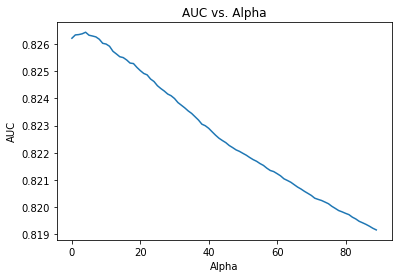

In [38]:
from sklearn.naive_bayes import MultinomialNB

test2 = np.arange(1, 10, 0.1)

test = [get_auc_CV(MultinomialNB(alpha=i)) for i in test2] 
res = pd.Series(test)

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

### 2.2. Evaluation on Validation Set

To evaluate the performance of our model, we will calculate the accuracy rate and the AUC score of our model on the validation set.

In [39]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

By combining TF-IDF and the Naive Bayes algorithm, we achieve the accuracy rate of **72.65%** on the validation set. This value is the baseline performance and will be used to evaluate the performance of our fine-tune BERT model. 

AUC: 0.8156
Accuracy: 72.20%


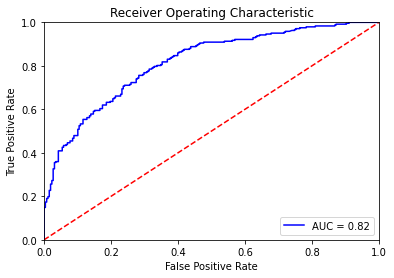

In [40]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=4)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

# D - Fine-tuning BERT

## 1. Install the Hugging Face Library

The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [ ]:
!pip install transformers==2.8.0

     |████████████████████████████████| 573kB 8.1MB/s 
     |████████████████████████████████| 870kB 20.7MB/s 
     |████████████████████████████████| 1.0MB 32.8MB/s 
     |████████████████████████████████| 3.7MB 54.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.40-cp36-none-any.whl size=893351 sha256=561d70bbfb42d1cff03992de3b62048b6d70d8696c8f59a0956ac41130b95599
  Stored in directory: /root/.cache/pip/wheels/ba/44/6e/939fb8625572dca96344566c5167bc4f8ab079294509898141
Successfully built sacremoses


## 2. Tokenization and Input Formatting

Before tokenizing our text, we will perform some slight processing on our text including removing entity mentions (eg. @united) and some special character. The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences.

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  @united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?
Processed:  I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on & check in. Can you help?


### 2.1. BERT Tokenizer

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The `encode_plus` method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special `[CLS]` and `[SEP]` tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.






In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Before tokenizing, we need to specify the maximum length of our sentences.

In [ ]:
# Concatenate train data and test data
all_tweets = np.concatenate([data.tweet.values, test_data.tweet.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  68


Now let's tokenize our data.

In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  @united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?
Token IDs:  [101, 1045, 1005, 1049, 2383, 3314, 1012, 7483, 1045, 2128, 8654, 2098, 2005, 2484, 2847, 2044, 1045, 2001, 4011, 2000, 4875, 1010, 2085, 1045, 2064, 1005, 1056, 8833, 2006, 1004, 4638, 1999, 1012, 2064, 2017, 2393, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


### 2.2. Create PyTorch DataLoader

We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## 3. Train Our Model

### 3.1. Create BertClassifier

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the `[CLS]` token is used as the features of the sequence to feed a classifier.

The `transformers` library has the [`BertForSequenceClassification`](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification) class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the `[CLS]` token and a single-hidden-layer feed-forward neural network as our classifier.

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 38 µs, sys: 0 ns, total: 38 µs
Wall time: 40.1 µs


### 3.2. Optimizer & Learning Rate Scheduler

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

Huggingface provided the [run_glue.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) script, an examples of implementing the `transformers` library. In the script, the AdamW optimizer is used.

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### 3.3. Training Loop

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (`loss.backward()`)
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (`optimizer.step()`)
- Update the learning rate (`scheduler.step()`)

Evaluation:
- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

The script below is commented with the details of our training and evaluation loop. 

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Now, let's start training our BertClassifier!

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.630467   |     -      |     -     |   7.58   
   1    |   40    |   0.497330   |     -      |     -     |   7.01   
   1    |   60    |   0.502320   |     -      |     -     |   7.11   
   1    |   80    |   0.491438   |     -      |     -     |   7.19   
   1    |   95    |   0.486125   |     -      |     -     |   5.35   
----------------------------------------------------------------------
   1    |    -    |   0.524515   |  0.439601  |   78.81   |   35.54  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.287401   |     -      |     -     |   7.83   
   2    |   40    |   0.260870   |     -      |     -     |   7.

### 3.4. Evaluation on Validation Set

The prediction step is similar to the evaluation step that we did in the training loop, but simpler. We will perform a forward pass to compute logits and apply softmax to calculate probabilities.

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.9048
Accuracy: 80.59%


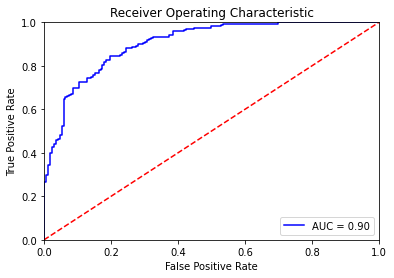

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

The Bert Classifer achieves 0.90 AUC score and 82.65% accuracy rate on the validation set. This result is 10 points better than the baseline method. 

### 3.5. Train Our Model on the Entire Training Data

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.664452   |     -      |     -     |   8.63   
   1    |   40    |   0.587205   |     -      |     -     |   8.42   
   1    |   60    |   0.522831   |     -      |     -     |   8.44   
   1    |   80    |   0.476442   |     -      |     -     |   8.23   
   1    |   100   |   0.467542   |     -      |     -     |   8.10   
   1    |   106   |   0.483039   |     -      |     -     |   2.14   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.338174   |     -      |     -     |   8.36   
   2    |   40    |   0.296080   |     -      |     -     |   7.93   
   2    |   60    |   0.295626   |     -      |     -     |   7.96

## 4. Predictions on Test Set

### 4.1. Data Preparation

Let's revisit out test set shortly.

In [ ]:
test_data.sample(5)

,id,tweet
471,18654,Friends and family: Never fly @JetBlue. Absol...
1971,76265,@DeltaAssist @rogerioad I never have had a pro...
23,672,First flight in weeks. Counting on you @Americ...
2702,103263,"""@USAirways: You know that we can__t stay no m..."
135,5137,@southwestair Here at SA Airport watching the ...


Before making predictions on the test set, we need to redo processing and encoding steps done on the training data. Fortunately, we have written the `preprocessing_for_bert` function to do that for us.

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.tweet)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


### 4.2. Predictions

There are about 300 non-negative tweets in our test set. Therefore, we will keep adjusting the decision threshold until we have about 300 non-negative tweets.

The threshold we will use is 0.992, meaning that tweets with a predicted probability greater than 99.2% will be predicted positive. This value is very high compared to the default 0.5 threshold.

After manually examining the test set, I find that the sentiment classification task here is even difficult for human. Therefore, a high threshold will give us safe predictions.

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

Number of tweets predicted non-negative:  454


Now we will examine 20 random tweets from our predictions. 17 of them are correct, showing that the BERT Classifier acquires about 0.85 precision rate.

In [ ]:
output = test_data[preds==1]
list(output.sample(20).tweet)

["@Delta @DeltaAssist Delta strikes out again. Sky lounge at the country's busiest airport closed on weekends. Dumb &amp; cheap. miss you @united",
 '.@SouthwestAir brought back honey roasted peanuts. Is it sad that this realization may be the high point in my day?#SmallThingsInLife',
 '@DeltaAssist I emailed kana@delta and contactus.delta@delta to resolve issues two weeks ago w/o response.  advice on who to contact?',
 "Woman With Kicked Off Flight By @AlaskaAir Because So Has #Cancer Plans to Donate Her Family's Airfare http://t.co/Uj6rispWLb",
 "@united (2/2) I didn't break the bag. If I didn't have to pay to check it, I wouldn't be as upset. Rather fly @AmericanAir @SouthwestAir etc",
 "I've flown about every airline &amp; never have I had a better experience than flying @JetBlue. Quality, service, comfort, &amp; affordability. A++",
 '@JetBlue  Best airline to work for miss u lots #keepingitminty ',
 'Convinced @firetweet to book a last minute trip to join me in Austin tom! Been s

# E - Conclusion

By adding a simple one-hidden-layer neural network classifier on top of BERT and fine-tuning BERT, we can achieve near state-of-the-art performance, which is 10 points better than the baseline method although we only have 3,400 data points.

In addition, although BERT is very large, complicated, and have millions of parameters, we only need to fine-tune it in only 2-4 epochs. That result can be achieved because BERT was trained on the huge amount and already encode a lot of information about our language. An impresive performance achieved in a short amount of time, with a small amount of data has shown why BERT is one of the most powerful NLP models available at the moment. 